# Ensemble model

In [2]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json
import pandas as pd
import pickle
import numpy as np
import xgboost as xgb
from keras.models import load_model
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [4]:
# Load Random Forest (pickle)
with open('Saved models/random_forest_best_model.pkl', 'rb') as file:
    rf = pickle.load(file)

In [5]:
# Load XGBoost model (JSON)
xgb = xgb.XGBClassifier()
xgb.load_model('Saved models/xgb_best_model.json')

In [7]:
# Load neural network model (keras)
nn = load_model('Saved models/NN_best_model.keras')

Let's create a function, which will take the previously trained models and either use a 'soft'- or a 'hard'-voting method to predict if a customer is a good or risky customer. 
- The soft voting takes each models predicted probability for the customer being risky and finds the average. If the average is above 0.5, the customer is predicted as risky. 
- The hard voting will let each model predict (vote) if a customer is a good or risky customers and the class with the most votes will be the ensemble models prediction.

In [ ]:
def votingClassifier(
        models: list, 
        model_names: list[str] = [],
        model_thresholds: list[float] = [],
        voting: str = 'hard',
        test_set: any = X_test
        ):
    """
    A voting classifier that supports soft and hard voting.
    
    Args:
        models (list): List of pre-trained models.
        model_names (list[str], optional): List of model names. If not provided, default names are assigned.
        model_thresholds (list[float], optional): List of thresholds for each model. If not provided, default threshold of 0.5 is used.
        voting (str, optional): 'soft' for averaging predicted probabilities,
                'hard' for majority voting on class predictions.
        test_set (any, optional): Test set for which predictions are required.

    Returns:
        If voting == 'soft':
            A tuple (final_preds, avg_probas) where:
              - final_preds is a 1D array of ensemble predictions.
              - avg_probas is a 2D array of averaged class probabilities.
              
        Else (hard voting):
            A tuple (final_preds, vote_arr) where:
              - final_preds is a 1D array of ensemble predictions.
              - vote_arr is a 2D array (n_models x n_samples) containing the individual predicted classes.
    """

    if test_set is None:
        raise ValueError("Please provide a valid test set.")
    
    voting = voting.lower()
    if voting not in ("soft", "hard"):
        raise ValueError("voting parameter must be either 'soft' or 'hard'")

    if not model_names:
        for i in range(len(models)):
            model_names.append(f'model_{i}')

    if len(models) != len(model_names):
        raise ValueError("models and model_names must be of equal length!")
    
    predictions = {}
    for model, name in zip(models, model_names):
        try:
            predictions[name] = model.predict_proba(test_set)[:, 1]
        except AttributeError: 
            predictions[name] = model.predict(test_set).flatten()  # for keras nerual network
    
    if voting == 'soft': # Soft voting: average the predicted probabilities across models.
        all_probas = np.array(list(predictions.values())) # Convert the dict values into a 3D array with shape (n_models, n_samples, n_classes)
        avg_probas = np.mean(all_probas, axis=0) # Calculate the mean probabilities
        final_preds = (avg_probas > 0.5).astype(int)

        return final_preds, avg_probas
    else: # Hard voting: for each model, choose the class with the highest probability
        if model_thresholds and (len(model_thresholds) == len(models)):
            # Use the provided thresholds for each model.
            vote_arr = np.array([(probas > thr).astype(int) for probas, thr in zip(predictions.values(), model_thresholds)]) # Convert the dict values into a 2D array with shape (n_models, n_samples) with the predicted value for each model
        else:
            # Fallback: use 0.5 as threshold for all models.
            vote_arr = np.array([(probas > 0.5).astype(int) for probas in predictions.values()]) # Convert the dict values into a 2D array with shape (n_models, n_samples) with the predicted value for each model
        n_samples = vote_arr.shape[1] 
        final_preds = []
        for i in range(n_samples): # For each sample, count votes across models.
            sample_votes = vote_arr[:, i]
            counts = np.bincount(sample_votes)
            # Choose the class with the highest count.
            final_preds.append(np.argmax(counts))
        final_preds = np.array(final_preds)
        return final_preds, vote_arr


Let's take the best thresholds that was found for the different models that was trained

In [ ]:
thresholds = pd.read_json('Model_metrics.json').loc['threshold']
thresholds

Now let's use the votingClassifier function, where we'll use it with 'hard' voting. 

In [12]:
test_predictions, votes = votingClassifier(
    models = [rf, xgb, nn],
    model_names = ['rf', 'xgb', 'nn'],
    model_thresholds=[thresholds['RandomForest'], thresholds['XGBoost'], thresholds['Neural Network']],
    voting = 'hard',
    test_set = X_test
)

   1/1067 [..............................] - ETA: 8:21

2025-02-15 11:47:07.354366: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1067/1067 [==============================] - 2s 2ms/step


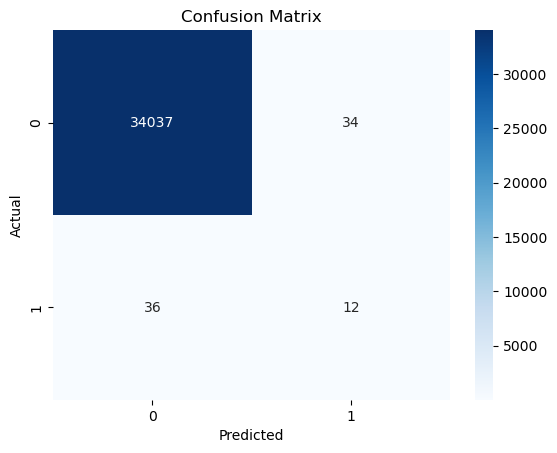

Recall       = 0.25
Precision    = 0.26
F1           = 0.26


In [18]:
result = get_result(Y_test, test_predictions)

In [19]:
save_metrics_to_json('Ensemble model', float(result['recall']), float(result['precision']), float(result['f1']))